# Diagnostic video

When doing an observation to commission a new instrument, or simply to know what's going on with a certain night, it is sometimes usefull to fully visualize the reduction process of raw images 🧐

In this case study we will see how to produce that with prose. One thing we want to monitor in the following observation is how well images are aligned and the quality of the PSF

## Retrieving the images

As usual, we parse our images folder with a ``FitsManager`` instance

In [2]:
from prose import FitsManager

fm = FitsManager("/Users/lgrcia/data/RAW_Callisto_20210927_Sp2315-0627_I+z/")
fm

RUN Parsing FITS: 100%|█████████████████| 255/255 [00:00<00:00, 1354.34images/s]


,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
4,2021-09-26,Callisto,,bias,,2048,2088,2
2,2021-09-26,Callisto,,dark,,2048,2088,8
15,2021-09-26,Callisto,I+z,flat,,2048,2088,13
1,2021-09-26,Callisto,I+z,light,Sp2315-0627,2048,2088,232


## Reference sequence

Since the goal is to align raw images, let's detect reference stars on a reference image.

INFO Building master bias
INFO Building master dark
INFO Building master flat


<AxesSubplot:>

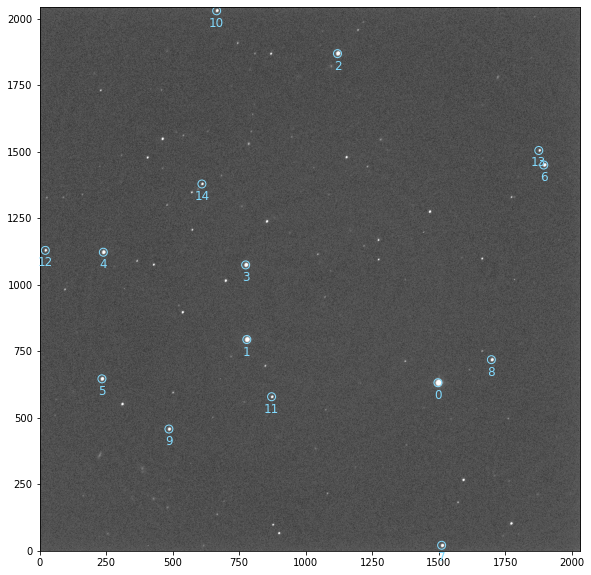

In [4]:
from prose import Image, Sequence, blocks

# We take one of the image as a reference one
reference = Image(fm.all_images[50])

# Defining the reference sequence
reference_sequence = Sequence([
    blocks.Calibration(fm.all_darks, fm.all_flats, fm.all_bias), # calibration
    blocks.Trim(),                                   # triming
    blocks.SegmentedPeaks(n_stars=15),               # stars detection
])

# Running it and displaying the reference stars
reference_sequence.run(reference, show_progress=False)
reference.show()

We can now reuse this sequence and apply it to the complete set of images.

## The rest of the sequence

Let's now build the sequence to take the measurements and align images

In [6]:
# Just running it on a test image
test_image = Image(fm.all_images[10])

main_sequence = Sequence([
    *reference_sequence,
    blocks.XYShift(reference),
    blocks.Cutouts(size=41),
    blocks.MedianPSF(),
    blocks.psf.Moffat2D()
])

main_sequence.run(test_image)

RUN 100%|█████████████████████████████████████| 1/1 [00:00<00:00,  1.10images/s]


## The ``PlotVideo`` block

To build a video of the reduction process of all images, we will use the ``PlotVideo`` block which takes as input a plotting function applied to an image. Let's write it

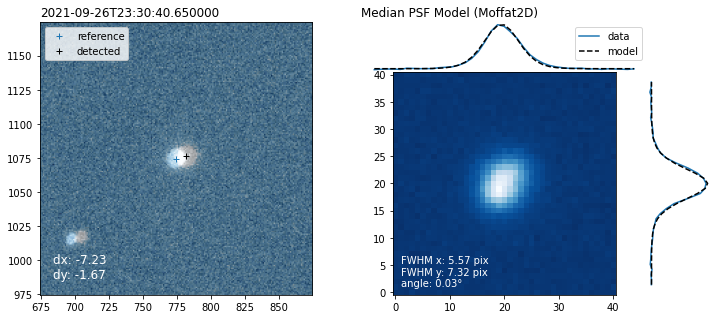

In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from prose import viz

# focusing plot on 
xy = reference.stars_coords[3]

def plot(image):
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    
    # Alignment
    subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1.])
    ax = subfigs[0].subplots(1, 1)
    reference.show_cutout(xy, ax=ax, cmap="Greys_r", stars=False)
    ax.plot(*reference.stars_coords.T, "+", c="C0", label="reference")
    image.show_cutout(xy, cmap="Blues_r", alpha=0.5, ax=ax, stars=False)
    ax.plot(*image.stars_coords.T, "+", c="k", label="detected")
    viz.corner_text(f"dx: {image.dx:.2f}\ndy: {image.dy:.2f}", c="w")
    ax.set_title(image.date.isoformat(), loc="left")
    plt.legend()
    
    # PSF
    axes = subfigs[1].subplots(2, 2, gridspec_kw=dict(
        width_ratios=[9, 2], 
        height_ratios=[2, 9],
        wspace=0,
        hspace=0))

    ax = axes[1, 0]
    axr = axes[1, 1]
    axt = axes[0, 0]
    axes[0, 1].axis("off")
    ax.imshow(image.psf, alpha=1, cmap="Blues_r", origin="lower")

    x, y = np.indices(image.psf.shape)

    axt.plot(y[0], np.mean(image.psf, axis=0), c="C0", label="data")
    axt.plot(y[0], np.mean(image.psf_model, axis=0), "--", c="k", label="model")
    axt.axis("off")
    axt.set_title(f"Median PSF Model ({image.psf_model_block})", loc="left")
    axt.legend()

    axr.plot(np.mean(image.psf, axis=1), y[0], c="C0")
    axr.plot(np.mean(image.psf_model, axis=1), y[0], "--", c="k")
    axr.axis("off")
    ax.text(1, 1, f"FWHM x: {image.fwhmx:.2f} pix\n"
                f"FWHM y: {image.fwhmy:.2f} pix\n"
                f"angle: {image.theta/np.pi*180:.2f}°", c="w")
        
    plt.tight_layout()
    

# Here is the result
plot(test_image)

And use it within the full sequence

In [9]:
process = Sequence([
    *main_sequence,
    blocks.vizualisation.PlotVideo(plot, "static/diagnostic_video.gif")
])

# only 10 images for example
process.run(fm.all_images[0:10])

RUN 100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.46s/images]


## A concise code

We have seen all the steps and details on how to use a plotting function within a sequence. For reference and clarity here is the final code containing the reference and main sequences:

In [14]:
from prose import Image, Sequence, blocks

# We take one of the image as a reference one
reference = Image(fm.all_images[50])

# Reference sequence
# ------------------
reference_sequence = Sequence([
    blocks.Calibration(fm.all_darks, fm.all_flats, fm.all_bias),  # calibration
    blocks.Trim(),                                                # triming
    blocks.SegmentedPeaks(n_stars=15),                            # stars detection
])

reference_sequence.run(reference, show_progress=False)

# Main Sequence
# -------------
main_sequence = Sequence([
    *reference_sequence,
    blocks.XYShift(reference),          # computing shift
    blocks.Cutouts(size=41),            # extracting stars cutouts
    blocks.MedianPSF(),                 # combining into a median PSF
    blocks.psf.Moffat2D(),              # PSF model
    blocks.vizualisation.PlotVideo(     # Video block (here a gif to display in the notebook)
        plot, 
        "static/diagnostic_video.gif"
    )
])

main_sequence.run(fm.all_images[50:60]) # just 10 for example

INFO Building master bias
INFO Building master dark
INFO Building master flat


RUN 100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.15s/images]


![](static/diagnostic_video.gif)